<a href="https://colab.research.google.com/github/calibretaliation/DeepLearning20211/blob/main/siamese_net_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!git clone https://github.com/calibretaliation/DeepLearning20211.git

Cloning into 'DeepLearning20211'...
remote: Enumerating objects: 32706, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (240/240), done.
remote: Total 32706 (delta 144), reused 0 (delta 0), pack-reused 32466
Receiving objects: 100% (32706/32706), 1.68 GiB | 32.38 MiB/s, done.
Resolving deltas: 100% (202/202), done.
Checking out files: 100% (32430/32430), done.


## Import

In [1]:
# !pip install git+https://github.com/tensorflow/docs

In [2]:
#@title Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import random

import os
import pickle

import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications, layers, losses, optimizers, metrics, Model, callbacks
from tensorflow.keras.applications import resnet, mobilenet_v3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD


from pathlib import Path

# import tensorflow_docs as tfdocs
# import tensorflow_docs.modeling
# import tensorflow_docs.plots


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [5]:
#@title Load CSV

train_df = pd.read_csv('DeepLearning20211/data/train.csv')
test_df = pd.read_csv('DeepLearning20211/data/test.csv')

train_img_dir = Path('DeepLearning20211/data/train_images')
test_img_dir = Path('DeepLearning20211/data/test_images/')

# Drop images with duplicated p-hash value 
# train_df = train_df.drop_duplicates(subset=['image_phash']).reset_index(drop=True)

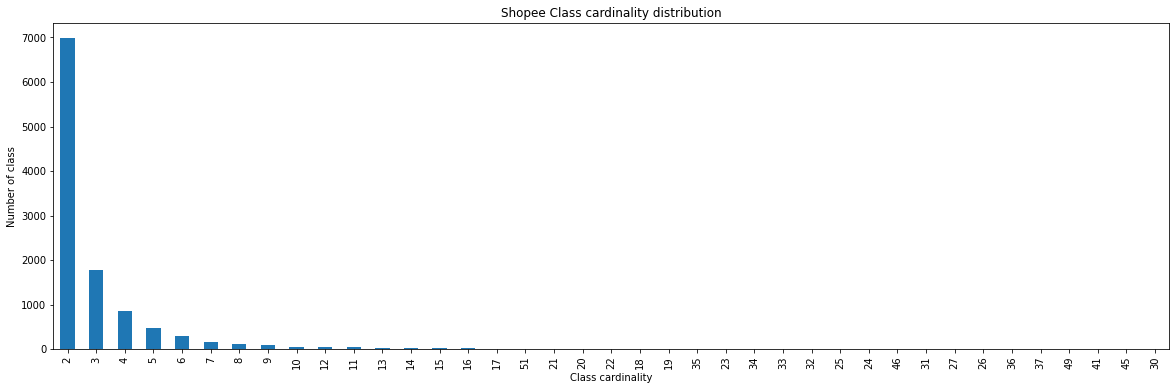

In [6]:
#@title Plot class cardinality distribution

# calculate number of images in each class
label_count = train_df['label_group'].value_counts()

plt.figure(figsize=(20, 6))
label_count.value_counts().plot.bar()
plt.xlabel('Class cardinality')
plt.ylabel('Number of class')
plt.title('Shopee Class cardinality distribution')
plt.show()

## Prepare dataset

In [ ]:
# #@title Take one instance in each class as anchor

# set_seed(42)
# anchor_df = train_df.groupby('label_group').nth(0)

In [7]:
#@title Create validation set

train_df['index'] = train_df.index
val_df = train_df.sample(frac=1, random_state=14).groupby('label_group').nth(0)
val_df['label_group'] = val_df.index
val_df = val_df.set_index('index')
train_df = train_df.drop('index', axis=1)
train_df = train_df.drop(index=val_df.index).reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [ ]:
# import shutil
# shutil.rmtree(str(temp_dir), ignore_errors=True)

# hmmm

In [8]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [9]:
import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import top_k_accuracy_score
import seaborn as sns
from matplotlib import cm

In [10]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label_group'])

LabelEncoder()

In [11]:
batch_size = 64

data_augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.RandomRotation(0.5),
     tf.keras.layers.RandomContrast(0.5),
     tf.keras.layers.RandomZoom((-0.2, 0.2)),
     tf.keras.layers.RandomTranslation(0.14, 0.14),
     ]
)

def filepath_to_img(filepath):
    
    img_string = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img_string)

    # img = tf.image.convert_image_dtype(img, tf.float32) # to [0, 1]
    # img = tf.image.resize(img, (224, 224)) 

    return img

def configure_dataset(ds, mode, fine_tune=False):
    assert mode == 'training' or mode == 'validation', "mode should be 'training' or 'validation'" 
    
    ds = ds.map(lambda filepath, label: (filepath_to_img(filepath), label), 
                num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.map(lambda img, label: (tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True)(img), label),
                num_parallel_calls=tf.data.AUTOTUNE)
    
    if not fine_tune:               #######################################
        ds = ds.map(lambda img, label: (tf.keras.layers.Rescaling(1./255, offset=-1)(img), label),
                    num_parallel_calls=tf.data.AUTOTUNE)

    # if mode == 'training':
    ds = ds.map(lambda img, label: (data_augmentation(img), label), 
                num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.prefetch(buffer_size=2048)
    
    ds = ds.batch(batch_size)
    
    return ds

In [12]:
#@title Define embedding model (Run only once)
base_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3), include_top=False, include_preprocessing=True)

output = layers.Flatten()(base_model.output)
output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output)

embedding = Model(base_model.input, output, name='Embedding')

17620992/17605208 [==============================] - 0s 0us/step


In [ ]:
embedding.summary()

In [13]:
#@title Choose layer to freeze

layer_name = 'multiply_14' #@param {type: 'string'}

trainable = False
for layer in base_model.layers:
    if layer.name == layer_name:
        trainable = True
    layer.trainable = trainable




In [14]:
batch_loss_histories = {}
epoch_loss_histories = {'loss': [], 'val_loss': []}

In [15]:
class LossOnBatch(callbacks.Callback):
    def __init__(self, epoch):
        super(LossOnBatch, self).__init__()
        self.epoch = epoch
        batch_loss_histories[epoch] = []

    def on_train_batch_end(self, batch, logs=None):
        batch_loss_histories[self.epoch].append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs=None):
        epoch_loss_histories['loss'].append(logs.get('loss'))
        epoch_loss_histories['val_loss'].append(logs.get('val_loss'))

In [16]:
val_ds = pd.concat([val_df, val_df]).sort_index(axis=0)
val_labels = label_encoder.transform(val_ds['label_group'])
val_ds = tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep + val_ds['image'], val_labels))
val_ds = configure_dataset(val_ds, mode='validation', fine_tune=True)   # evaluation using keras pretrained-model

In [ ]:
embedding.compile(
    optimizer=SGD(learning_rate=5e-3, momentum=0.9, nesterov=True),
    loss=tfa.losses.TripletSemiHardLoss(),
    )

max_epoch = 3
for epoch in range(max_epoch):
    train_df = train_df.sample(frac=1.0).reset_index(drop=True)
    train_ds = pd.concat([train_df, train_df]).sort_index(axis=0)
    train_ds = tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep + train_ds['image'], label_encoder.transform(train_ds['label_group'])))
    train_ds = configure_dataset(train_ds, mode='training', fine_tune=True)     # training using keras pretrained-model

    print('Epoch %d/%d' % (epoch + 1, max_epoch))

    embedding.fit(
        train_ds,
        epochs=1,
        validation_data=val_ds,
        callbacks=[LossOnBatch(epoch)]
    )

Epoch 1/3


In [ ]:
anchor_ds = pd.concat([train_df for _ in range(4)]).sort_index(axis=0)
anchor_labels = label_encoder.transform(anchor_ds['label_group'])
anchor_ds = tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep + anchor_ds['image'], anchor_labels))
anchor_ds = configure_dataset(anchor_ds, mode='training', fine_tune=True)
anchor_embeddings = embedding.predict(anchor_ds)

In [ ]:
with open('/content/drive/MyDrive/checkpoint/anchor_embeddings.pkl', 'wb') as f:
    pickle.dump(anchor_embeddings, f)

with open('/content/drive/MyDrive/checkpoint/anchor_labels.pkl', 'wb') as f:
    pickle.dump(anchor_labels, f)

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=4)
KNN.fit(anchor_embeddings, anchor_labels)

KNeighborsClassifier(n_neighbors=4)

In [ ]:
val_embeddings = embedding.predict(val_ds)

In [ ]:
val_preds = KNN.predict_proba(val_embeddings)

In [ ]:
top_k_accuracy_score(val_labels, val_preds, k=1)

0.9908215194474737

In [ ]:
pca = PCA(n_components=2)
decomposed_embeddings = pca.fit_transform(anchor_embeddings)

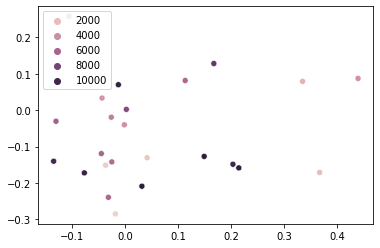

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=decomposed_embeddings[:100, 0], 
                y=decomposed_embeddings[:100, 1], 
                hue=anchor_labels[:100], 
                palette=cm.get_cmap('Spectral')
)

In [ ]:
embedding.save('/content/drive/MyDrive/checkpoint/embedding')

In [ ]:
embedding = tf.keras.models.load_model('/content/drive/MyDrive/checkpoint/embedding')

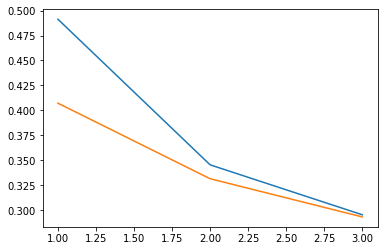

In [ ]:
loss_hist = [_.history['loss'] for _ in epoch_histories]
val_loss_hist = [_.history['val_loss'] for _ in epoch_histories]
plt.plot(range(1, max_epoch + 1), loss_hist, label='loss')
plt.plot(range(1, max_epoch + 1), val_loss_hist, label='val_loss')
plt.show()

In [ ]:
ncols = 3
nrows = 3
plt.figure(figsize=(4*ncols, 4*nrows))
spec = gridspec.GridSpec(ncols=ncols, nrows=nrows)
for img_batch, label_batch in train_ds.take(1):
    i = 0
    for img, label in zip(img_batch, label_batch):
        plt.subplot(spec[i])
        plt.imshow(img)
        plt.title(label.numpy())
        plt.axis('off')

        i += 1
        if i == nrows * ncols:
            break
plt.show()

# Depricated

In [ ]:
#@title Define embedding model (Run only once)
base_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

output = layers.Flatten()(base_model.output)
output = layers.Dense(512, activation='relu')(output)
output = layers.BatchNormalization()(output)
output = layers.Dense(256, activation='relu')(output)
output = layers.BatchNormalization()(output)
output = layers.Dense(256, activation='relu')(output)
output = layers.BatchNormalization()(output)

embedding = Model(base_model.input, output, name='Embedding')


In [ ]:
embedding.summary()

In [ ]:
#@title Choose layer to freeze

layer_name = 'multiply_61' #@param {type: 'string'}

trainable = False
for layer in base_model.layers:
    if layer.name == layer_name:
        trainable = True
    layer.trainable = trainable

class Distance(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance

anchor_input = layers.Input(name='anchor', shape=(224, 224, 3))
positive_input = layers.Input(name='positive', shape=(224, 224, 3))
negative_input = layers.Input(name='negative', shape=(224, 224, 3))

distances = Distance()(
    embedding(mobilenet_v3.preprocess_input(anchor_input)),
    embedding(mobilenet_v3.preprocess_input(positive_input)),
    embedding(mobilenet_v3.preprocess_input(negative_input))
)

siamese_base = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=distances
)

class SiameseNet(Model):
    """
    Siamese network with triplet loss:
        L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """
    def __init__(self, siamese_base, margin=0.5):
        super(SiameseNet, self).__init__()
        self.siamese_base = siamese_base
        self.margin = margin
        self.loss_tracker = metrics.Mean(name='loss')

    def call(self, inputs):
        return self.siamese_base(inputs)

    @tf.function
    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_base(data)
        loss = tf.maximum(ap_distance + self.margin - an_distance, 0.0)
        return loss

    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_base.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_base.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {'loss': self.loss_tracker.result()}

    @tf.function
    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {'val_loss': self.loss_tracker.result()}

    @property
    def metrics(self):
        # list our metrics here so the `reset_states()` can be called automatically.
        return [self.loss_tracker]



In [ ]:
class SaveModelOnBatch(callbacks.Callback):
    def __init__(self, n, path, terminate_batch=None):
        super(SaveModelOnBatch, self).__init__()
        self.n = n
        self.path = path
        self.terminate_batch = terminate_batch

    def on_train_batch_end(self, batch, logs=None):
        if batch > 0 and batch % self.n == 0:
            print('Current loss:', logs.get('loss'))
            embedding.save(self.path + os.sep + 'embedding')
            print('embedding saved at', self.path + os.sep + 'embedding')
            # siamese_base.save(self.path + os.sep + 'siamese_base')
            # print('siamese_base saved at', self.path + os.sep + 'siamese_base')
        if batch == self.terminate_batch:
            self.model.stop_training = True
            return

In [ ]:
model = SiameseNet(siamese_base, 1.0)
model.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.9, nesterov=True))
history = model.fit(train_ds, 
          epochs=2, 
          validation_data=val_ds, 
          shuffle=True, 
          callbacks=[SaveModelOnBatch(200, '/content/drive/MyDrive/checkpoint'),
                    #  callbacks.ReduceLROnPlateau(monitor="loss", factor=0.1, patience=1, verbose=1),
                    #  callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)
                     ]
)

Epoch 1/2
  200/34388 [..............................] - ETA: 68:10:51 - loss: 0.9034Current loss: 0.9027803540229797
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  400/34388 [..............................] - ETA: 69:30:45 - loss: 0.8640Current loss: 0.8638365268707275
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  600/34388 [..............................] - ETA: 70:01:35 - loss: 0.8315Current loss: 0.8313974738121033
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  800/34388 [..............................] - ETA: 69:50:16 - loss: 0.8076Current loss: 0.8075528144836426
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1000/34388 [..............................] - ETA: 69:42:29 - loss: 0.7893Current loss: 0.7893808484077454
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1200/34388 [>.............................] - ETA: 69:29:54 - loss: 0.7693Current loss: 0.7691348791122437
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1400/34388 [>.............................] - ETA: 69:13:29 - loss: 0.7498Current loss: 0.7497460842132568
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1600/34388 [>.............................] - ETA: 68:56:01 - loss: 0.7347Current loss: 0.7345338463783264
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1800/34388 [>.............................] - ETA: 68:40:12 - loss: 0.7186Current loss: 0.7184807062149048
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 2000/34388 [>.............................] - ETA: 68:18:45 - loss: 0.7041Current loss: 0.7040671706199646
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 2088/34388 [>.............................] - ETA: 68:27:57 - loss: 0.6989

batch = 64 hội tụ nhanh hơn 32

In [ ]:
embedding.save('/content/drive/MyDrive/checkpoint/embedding')

In [ ]:
embedding = tf.keras.models.load_model('/content/drive/MyDrive/checkpoint/embedding_0')

In [ ]:
%%time

anchor_paths = (str(train_img_dir) + os.sep + anchor_df['image']).to_list()
anchor_label_group = anchor_df.index.to_list()

anchor_embedding = embedding.predict(
    mobilenet_v3.preprocess_input(
        tf.data.Dataset.from_tensor_slices(anchor_paths).map(
            filepath_to_img, num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(buffer_size=512).batch(32)
    )
)

# anchor_embedding = tf.data.Dataset.from_tensor_slices(anchor_embedding)

CPU times: user 2min, sys: 6.68 s, total: 2min 6s
Wall time: 1min 19s


In [ ]:
# %%time

label_group_to_anchor_index = np.vectorize(lambda label_group: anchor_label_group.index(label_group))

val_predictions = tf.data.Dataset.from_tensor_slices(str(train_img_dir) + os.sep +  val_df['image'])

val_predictions = val_predictions.map(lambda filepath: tf.squeeze(embedding(tf.expand_dims(mobilenet_v3.preprocess_input(data_augmentation(filepath_to_img(filepath))), axis=0))))
val_predictions = val_predictions.prefetch(buffer_size=11004)

val_predictions = val_predictions.map(lambda embedding_vector: tf.map_fn(lambda x: 1/tf.reduce_sum(tf.square(x - embedding_vector)), anchor_embedding))

In [ ]:
label = label_group_to_anchor_index(val_df['label_group'])
pred = [p for p in val_predictions]

In [ ]:
val_accuracy = metrics.SparseCategoricalAccuracy()

for l, p in zip(label, pred):
    val_accuracy.update_state(l, p)  

val_accuracy.result()  